# Assignment 1 Part 2: Ray Volume Intersection

In this assignment, you are going to learn about representation of geometry as occupancy grid and how to render it.

In [6]:
import pathlib
import numpy as np
from matplotlib import pyplot as plt

import slangpy as spy
from pyglm import glm
import open3d as o3d
from tqdm.notebook import tqdm

from cs248a_renderer import setup_device, RendererModules
from cs248a_renderer.model.mesh import Mesh, create_triangle_buf
from cs248a_renderer.model.volumes import DenseVolume, create_volume_buf
from cs248a_renderer.model.scene import Scene
from cs248a_renderer.model.bvh import BVH, create_bvh_node_buf
from cs248a_renderer.renderer.core_renderer import Renderer

In [7]:
# We setup the device and renderer similar to part 1
bvh_shader_path = pathlib.Path.cwd() / "shaders"
device = setup_device([bvh_shader_path])
renderer_modules = RendererModules(device)
assignment1_module = spy.Module.load_from_file(
    device=device,
    path="assignment1.slang",
    link=[renderer_modules.texture_module]
)

[INFO] (rhi) layer: CreateDevice: Debug layer is enabled.
[WARN] No supported shader model found, pretending to support sm_6_0.
[WARN] Slang compiler warnings:
/Users/stephone/Documents/school/cs248/asst1/src/cs248a_renderer/slang_shaders/./texture/texture.slang(28): warning 30081: implicit conversion from 'vector<float,3>' to 'vector<uint,3>' is not recommended
        uint3 voxelCoord = round(uvw * tex.size);
                                ^



## Volumetric Representation of Shapes

Volumetric shapes fill a regular 3D grid, where each cell of grid represent a tiny cube of space storing properties of a point in 3D space. Simplest way to represent a surface would by by encoding the properties of ocupancy (whether a surface exists at this point or not) and color (at the surface point) at a voxel, essentially having a grid of size HxWxD and at each grid cell (called as a 'voxel') we'd have a vector of size 4 to encode RGB color and occupancy (0/1).

### Visualizing Occupancy grids

As you might have guessed, the grid-like representation introduces quantization artefacts since a surface is continuous by nature (we're going learn to retain this property when we'll render SDFs). But what if I want to know the color and occupancy at any arbitrary point?

To accomplish task, we turn to interpolation techniques. In this exercise, we are going to visualize a slice of volume using two types of interpolations: nearest and tri-linear interpolation.

Download the `sdf_volume_low_res.npy` file from the  assignment 1 resources folder: https://drive.google.com/drive/folders/1IHUzNzK4TwybdGrdUOpoYpKfIZEC9VVY?usp=share_link and save it in the `resources` directory.

This volume is stored in a 3D numpy array of size 32x32x32, where each voxel contains a single float value representing occupancy at that point. For now, you can assume the occupancy value is 1.0 inside the surface and 0.0 outside the surface.

In the following cell, we're also loading a default color for the volume (red). You can ignore the color part for now since we're only interested in visualizing the occupancy values.

In [8]:
# Load the volume density data from the provided .npy file.
volume_density = np.load("../../resources/sdf_volume_low_res.npy")
# Fill the RGB channel with colors.
VOLUME_COLOR = [1.0, 0.0, 0.0]
volume_color = np.full(volume_density.shape + (3,), VOLUME_COLOR, dtype=np.float32)
np_volume = np.concatenate(
    [volume_color, volume_density[..., np.newaxis]], axis=-1
)
np_volume.shape

(32, 32, 32, 4)

### Nearest Neighbor Interpolation

Nearest Neighbor is the simplest way to assign properties to a point **p**. Instead of blending values, we simply look for the single voxel **v** that is physically closest to **p** and adopt its properties (like color and occupancy) entirely.

#### How it Works
Imagine every voxel is the center of a small cube of influence. If point **p** falls anywhere inside that cube, it "snaps" to that voxel's value. 
* It is computationally very fast because it requires no averaging.
* It effectively treats the volume as a collection of discrete blocks rather than a continuous field.

Now, implement the `pointSample` function in `src/cs248a_renderer/slang_shaders/texture/texture.slang` to perform nearest neighbor sampling. The function is taking a `SharedTexture3D` object and a 3D coordinate `uvw` (in [0, 1] range) as input and should return the voxel value at the nearest neighbor.

To get the voxel value from the `SharedTexture3D` object, you can use the `getBufferValue` and pass in the voxel coorinates as a `uint3` object. The voxel coordinates should range from (0, 0, 0) to (size.x-1, size.y-1, size.z-1).

Once you implement the nearest neighbor sampling, you should get a visualization similar to the one below:

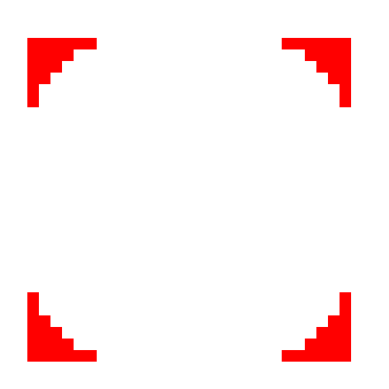

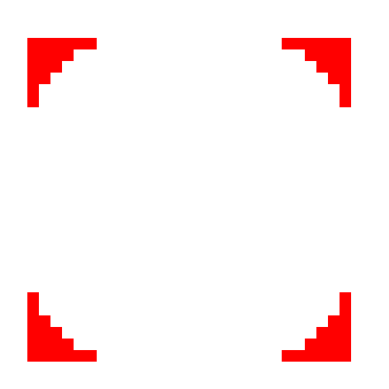

In [9]:
OUTPUT_IMG_SIZE = (512, 512)
output_image = device.create_texture(
    type=spy.TextureType.texture_2d,
    format=spy.Format.rgba32_float,
    usage=spy.TextureUsage.unordered_access,
    width=OUTPUT_IMG_SIZE[0],
    height=OUTPUT_IMG_SIZE[1],
)
np_volume_reshape = np_volume.reshape(-1, 4)
volume_tex_buf = spy.NDBuffer(
    device=device,
    dtype=assignment1_module.float4,
    shape=(np_volume_reshape.shape[0], )
)
volume_tex_buf.copy_from_numpy(np_volume_reshape)
assignment1_module.sliceNearestSample(
    tid=spy.grid(OUTPUT_IMG_SIZE),
    canvasSize=[OUTPUT_IMG_SIZE[0], OUTPUT_IMG_SIZE[1]],
    volumeTexBuf={
        "buffer": volume_tex_buf
    },
    volumeTex={
        "size": [np_volume.shape[2], np_volume.shape[1], np_volume.shape[0]],
        "offset": 0
    },
    slice=0.25,
    _result=output_image
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()

### Tri-Linear Interpolation
While **Nearest Neighbor** is fast, it creates a "stepped" environment where properties jump abruptly from one voxel to the next. To achieve smooth surfaces and realistic lighting, we use **Tri-Linear Interpolation**, which treats the space between voxels as a continuous blend rather than a series of hard boundaries.

Instead of "snapping" to the single closest voxel, we look at the **8 surrounding voxels** that form a cube (or "cell") around point **p**. We then calculate a weighted average of their properties based on **p**'s position within that cube.
  
Implement the `trilinearSample` function in `src/cs248a_renderer/slang_shaders/texture/texture.slang` to perform nearest neighbor sampling. The function is taking a `SharedTexture3D` object and a 3D coordinate `uvw` (in [0, 1] range) as input and should return the voxel value interpolated trilinearly using the surrounding voxels.

To get the voxel value from the `SharedTexture3D` object, you can use the `getBufferValue` and pass in the voxel coorinates as a `uint3` object. The voxel coordinates should range from (0, 0, 0) to (size.x-1, size.y-1, size.z-1).

Once you implement the trilinear sampling, you should get a visualization similar to the one below:

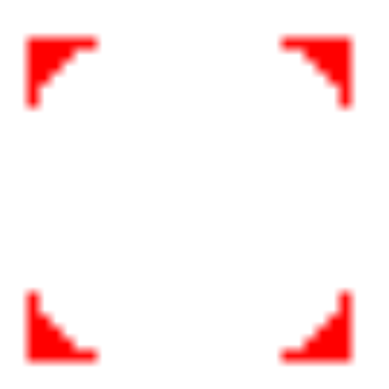


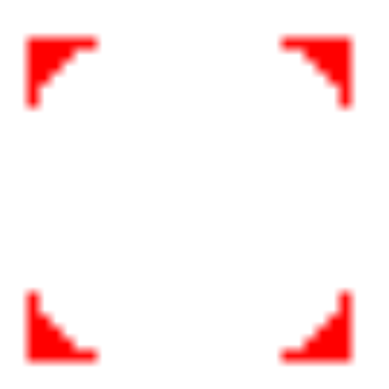

In [10]:
OUTPUT_IMG_SIZE = (512, 512)
output_image = device.create_texture(
    type=spy.TextureType.texture_2d,
    format=spy.Format.rgba32_float,
    usage=spy.TextureUsage.unordered_access,
    width=OUTPUT_IMG_SIZE[0],
    height=OUTPUT_IMG_SIZE[1],
)
np_volume_reshape = np_volume.reshape(-1, 4)
volume_tex_buf = spy.NDBuffer(
    device=device,
    dtype=assignment1_module.float4,
    shape=(np_volume_reshape.shape[0], )
)
volume_tex_buf.copy_from_numpy(np_volume_reshape)
assignment1_module.sliceTrilinearSample(
    tid=spy.grid(OUTPUT_IMG_SIZE),
    canvasSize=[OUTPUT_IMG_SIZE[0], OUTPUT_IMG_SIZE[1]],
    volumeTexBuf={
        "buffer": volume_tex_buf
    },
    volumeTex={
        "size": [np_volume.shape[2], np_volume.shape[1], np_volume.shape[0]],
        "offset": 0
    },
    slice=0.25,
    _result=output_image
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()

## Rendering a Volume

As we've seen previously, rendering any surface requires us to determine the point of ray-surface intersection. You've previously implemented ray-triangle intersection. Now, we are going to use the same principles to determine ray-voxel intersection point.

In [11]:
# We are creating a dense volume SceneObject and storing the numpy 
# volume data in it. Voxel size is 1/16 units. Our data is 
# stored in a 32x32x32 voxel grid, so the total size of our volume is 
# 2x2x2 units.
volume = DenseVolume(
    name="volume",
    data=np_volume,
    properties={
        "voxel_size": 1 / 16,
        "pivot": (0.5, 0.5, 0.5),
    }
)
volume.transform.position = glm.vec3(0.0, 0.0, 0.0)
volume.transform.rotation = glm.quat(1.0, 0.0, 0.0, 0.0)

In [12]:
# We'll load the Volume model into our scene.
scene = Scene()
scene.add_object(volume)
cam = scene.camera
cam_pos = glm.vec3(3.0, 2.0, 3.0)
cam.transform.position = cam_pos
cam.transform.rotation = glm.quatLookAt(glm.normalize(-cam_pos), glm.vec3(0.0, 1.0, 0.0))
scene

SceneObject(name=root, transform=Transform3D(position=vec3( 0, 0, 0 ), rotation=quat( 1, 0, 0, 0 ), scale=vec3( 1, 1, 1 )), children=[
  SceneObject(name=volume, transform=Transform3D(position=vec3( 0, 0, 0 ), rotation=quat( 1, 0, 0, 0 ), scale=vec3( 1, 1, 1 )), children=[
  ])
])

In [13]:
OUTPUT_IMG_SIZE = (512, 512)
output_image = device.create_texture(
    type=spy.TextureType.texture_2d,
    format=spy.Format.rgba32_float,
    usage=spy.TextureUsage.unordered_access,
    width=OUTPUT_IMG_SIZE[0],
    height=OUTPUT_IMG_SIZE[1],
)

### Ray Marching to find a Hit Point

In the case of triangles, we could analytically determine the point of ray-triangle intersection. However, in the case of voxel representation this is not possible. Therefore, we have evaluation each point along the ray until we find an occupied point. We are going to use our knowledge of sampling to determine the occupancy of a 3D point in a voxel grid.

Implement the `hit` function for the primitive of volume defined in `src/cs248a_renderer/slang_shaders/primitive/volume.slang`. It accepts a `ray` and `volumeTexBuf` containing the volume data. To sample from the volume use `volumeTexBuf.trilinearSample(tex, uvw)`, where `uvw` is texture coordinate ranging from 0-1.

In [14]:
renderer = Renderer(
    device=device,
    render_texture=output_image,
    render_modules=renderer_modules
)

Upon implementing the ray-volume `hit` function, now you're ready to render the volumes in the scene. Remember that the `hit` function returns a `RayHitResult` struct that stores the point along the ray that hit the surface. Now, we are going to use this to render all the volumes in the scene.

In `src/cs248a_renderer/slang_shaders/renderer.slang` implement the Ray-Volume intersection test in `sample` function by cycling over all the volumes in the scene. Note that, this function also contains the ray-triangle intersection test from Part 1 of this assignment. In the similar spirit, we continue to test over all the volumes in the scene.

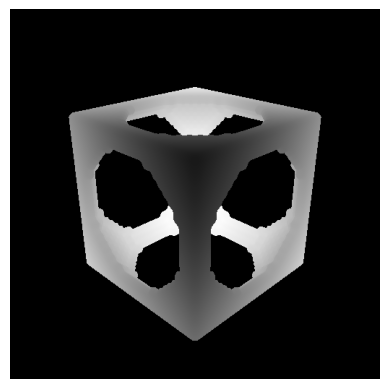

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0714285..1.0046794].


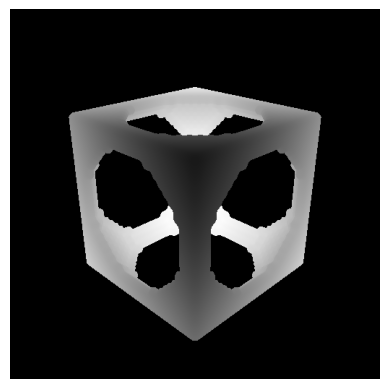

In [15]:
renderer.load_volumes(scene)
renderer.render(
    view_mat=cam.view_matrix(),
    fov=cam.fov,
    render_depth=True,
)
output_np = output_image.to_numpy()
output_np[:, :, :3] -= 3
output_np[:, :, :3] /= 2.8
plt.imshow(np.flipud(output_np))
plt.axis('off')
plt.show()

### Computing Normal at Hit Point

Normal at a surface point is defined as the direction along with there maximum change in the occupancy function. For eg. in the case of planar surfaces like triangles, the occupancy function transitions abruptly from 0 (outside) to 1 (inside). Since any movement within the plane of the triangle results in no change in occupancy, the direction of maximum change must be strictly perpendicular to the surface, hence the cross-product of plane in which the triangle exists is its normal.

#### Extension to Voxels
In a 3D voxel grid, the occupancy function $O(x, y, z)$ is discrete. We extend the concept of "maximum change" by treating the grid as a scalar field and computing the **gradient** ($\nabla O$) using **finite differences**.

##### 1. Central Difference Approximation
At a hit point within the grid, the normal is estimated by comparing the occupancy values of neighboring voxels along each axis:

* **x-axis:** $g_x = O(x+\Delta, y, z) - O(x-\Delta, y, z)$
* **y-axis:** $g_y = O(x, y+\Delta, z) - O(x, y-\Delta, z)$
* **z-axis:** $g_z = O(x, y, z+\Delta) - O(x, y, z-\Delta)$



##### 2. Normalization
The final surface normal is the unit vector of this gradient:
$$\mathbf{n} = -\text{normalize}(g_x, g_y, g_z)$$

Inside the ray-volume `hit` function, we are now going to return the estimated normal along with the `t` value in the `RayHitResult`.

A correct implementation will render a normal of the Volume like this:

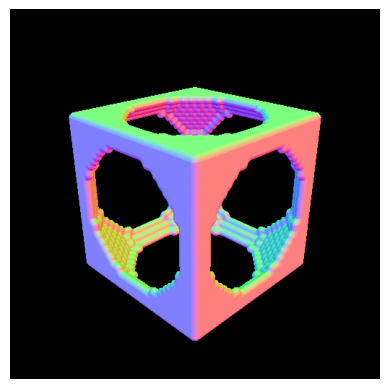

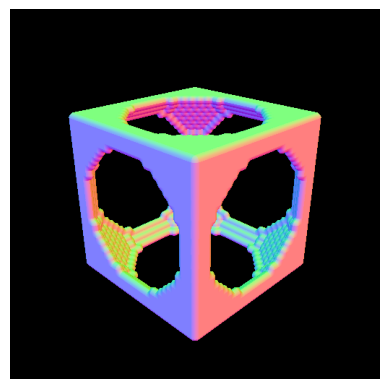

In [16]:
renderer.load_volumes(scene)
renderer.render(
    view_mat=cam.view_matrix(),
    fov=cam.fov,
    render_normal=True,
)
output_np = output_image.to_numpy()
plt.imshow(np.flipud(output_np))
plt.axis('off')
plt.show()

### Finally, let's render the occupancy grid

If all the implementaiton above is correct, the renderer should now render an image like this:

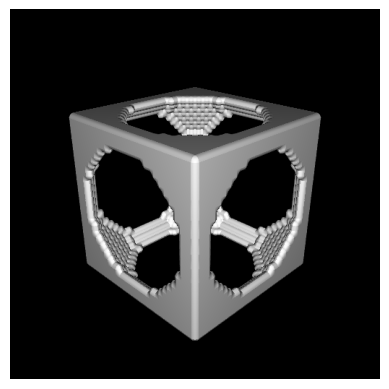


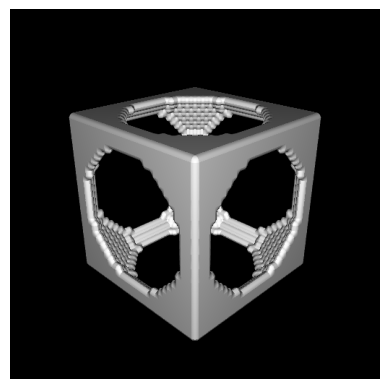

In [17]:
renderer.load_volumes(scene)
renderer.render(
    view_mat=cam.view_matrix(),
    fov=cam.fov,
)
output_np = output_image.to_numpy()
plt.imshow(np.flipud(output_np))
plt.axis('off')
plt.show()